This project is trying to predict hourly temperature using historical hourly temperature. 

Reference:
https://medium.com/@llmkhoa511/time-series-analysis-and-weather-forecast-in-python-e80b664c7f71

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

https://www.kaggle.com/poiupoiu/how-to-use-sarimax

https://online.stat.psu.edu/stat510/lesson/4/4.1

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv
/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv


In [2]:
weather = pd.read_csv('../input/energy-consumption-generation-prices-and-weather/weather_features.csv')
print(weather.shape)
print(weather.columns)

(178396, 17)
Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')


In [3]:
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


Convert dt_iso to datetime. Conver Kelvin temperature to Celsius. The goal of this practice is to predict temperature using previous temperature only, so only 3 variables are kept. 

In [4]:
weather['datetime'] = weather['dt_iso'].astype('str').str.slice(start = 0,stop = -6)
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather['celsius'] = weather['temp']- 273.15
w1 = weather[['city_name','celsius','datetime']]

Check how many observations in each city. 

In [5]:

w1.groupby(['city_name'])['datetime'].count()


city_name
 Barcelona    35476
Bilbao        35951
Madrid        36267
Seville       35557
Valencia      35145
Name: datetime, dtype: int64

The latest datetime in the dataset is 2018-12-31 23:00:00, which is the same for all cities.

In [6]:
w1.groupby(['city_name'])['datetime'].max()

city_name
 Barcelona   2018-12-31 23:00:00
Bilbao       2018-12-31 23:00:00
Madrid       2018-12-31 23:00:00
Seville      2018-12-31 23:00:00
Valencia     2018-12-31 23:00:00
Name: datetime, dtype: datetime64[ns]

The oldest datetime in the dataset is 2015-01-01 00:00:00.

In [7]:
w1.groupby(['city_name'])['datetime'].min()

city_name
 Barcelona   2015-01-01
Bilbao       2015-01-01
Madrid       2015-01-01
Seville      2015-01-01
Valencia     2015-01-01
Name: datetime, dtype: datetime64[ns]

There are 35064 hours from 2015-01-01 00:00:00 to 2018-12-31 23:00:00. However, all cities have more than 35064 observations of temperature. There must be some duplicates of datetime. Before deleting these duplicates, check if there is any NA values for these observations.  

In [8]:
w1.isnull().sum()

city_name    0
celsius      0
datetime     0
dtype: int64

There is no NA values. Check how many duplicates. 

In [9]:
w1_dup = w1[w1.duplicated()].groupby('city_name')['datetime'].count()
print(w1_dup)

city_name
 Barcelona     415
Bilbao         889
Madrid        1206
Seville        495
Valencia        84
Name: datetime, dtype: int64


All cities have less than 35064 observations after droping duplicates, which means there is some missing datetime in the dataset. 

In [10]:
w1_nodup = w1.drop_duplicates(subset = ['city_name','datetime'], keep = 'first')
print(w1_nodup.groupby('city_name')['datetime'].count())

city_name
 Barcelona    35060
Bilbao        35060
Madrid        35060
Seville       35060
Valencia      35060
Name: datetime, dtype: int64


Fill in missing datetime by setting the datetime as index. Fill in the 

In [11]:
# fill in missing datetime for each city, and combine them into one dataset. 
def fill_dt(data, city):
    dt_fill = pd.DataFrame(columns = data.columns)
    for c in city:
        temp = data[data['city_name'] == c]
        temp = temp.set_index('datetime').resample('60min').ffill().reset_index() 
        dt_fill = dt_fill.append(temp)
    return dt_fill

In [12]:
ct = list(w1_nodup['city_name'].unique())
w1_fdate = fill_dt(w1_nodup, ct)
w1_fdate.head()

,city_name,celsius,datetime
0,Valencia,-2.675,2015-01-01 00:00:00
1,Valencia,-2.675,2015-01-01 01:00:00
2,Valencia,-3.464,2015-01-01 02:00:00
3,Valencia,-3.464,2015-01-01 03:00:00
4,Valencia,-3.464,2015-01-01 04:00:00


Convert datetime to date and hour. 

In [13]:
w1_fdate['date'] = w1_fdate['datetime'].dt.date
w1_fdate['hour'] = w1_fdate['datetime'].dt.hour
w1_fdate.head()

,city_name,celsius,datetime,date,hour
0,Valencia,-2.675,2015-01-01 00:00:00,2015-01-01,0
1,Valencia,-2.675,2015-01-01 01:00:00,2015-01-01,1
2,Valencia,-3.464,2015-01-01 02:00:00,2015-01-01,2
3,Valencia,-3.464,2015-01-01 03:00:00,2015-01-01,3
4,Valencia,-3.464,2015-01-01 04:00:00,2015-01-01,4


Plot daily average/sd temperature for four city from 2015-01-01 to 2018-12-31. Check if the time series is stationary using plots.

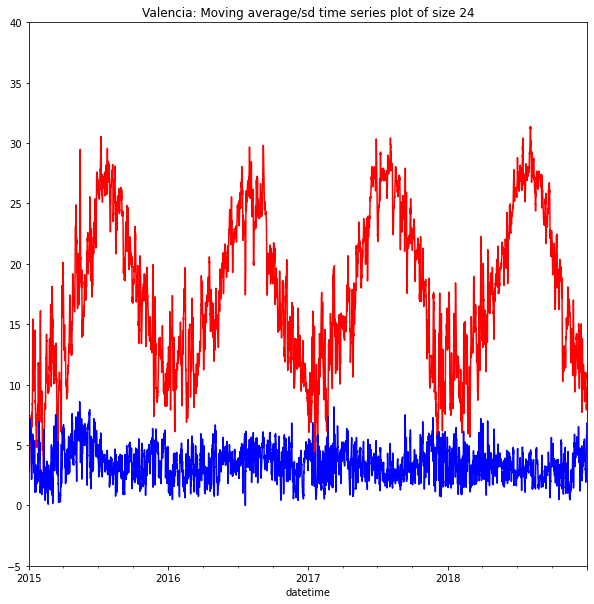

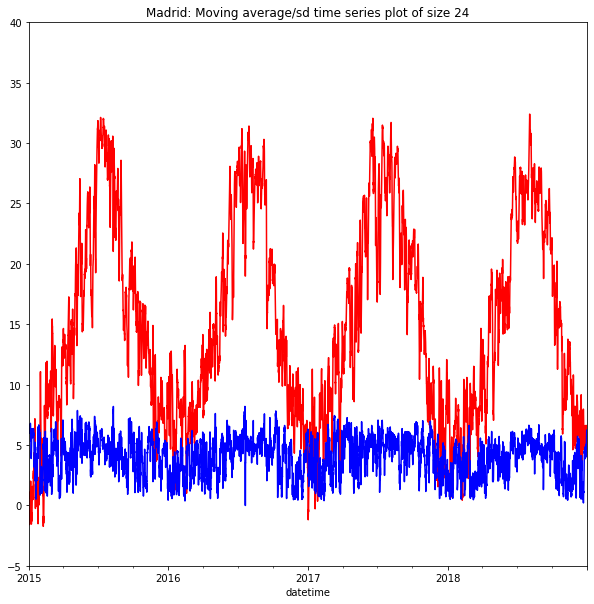

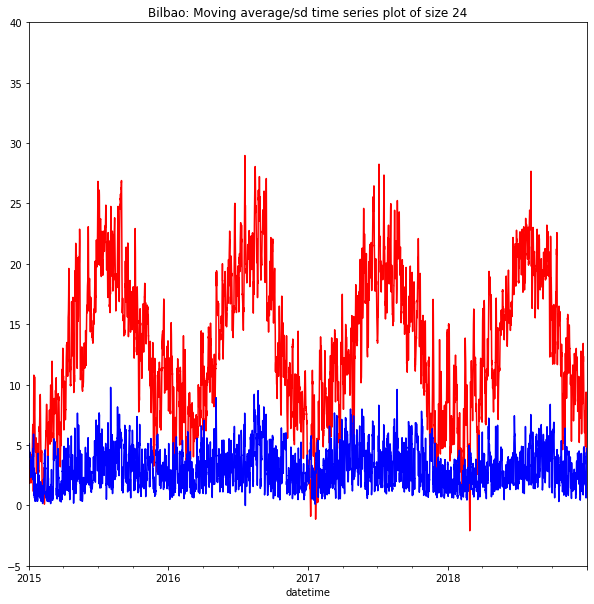

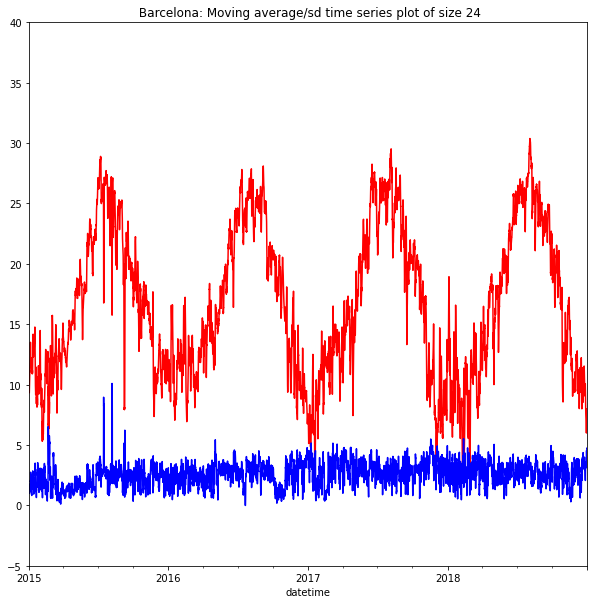

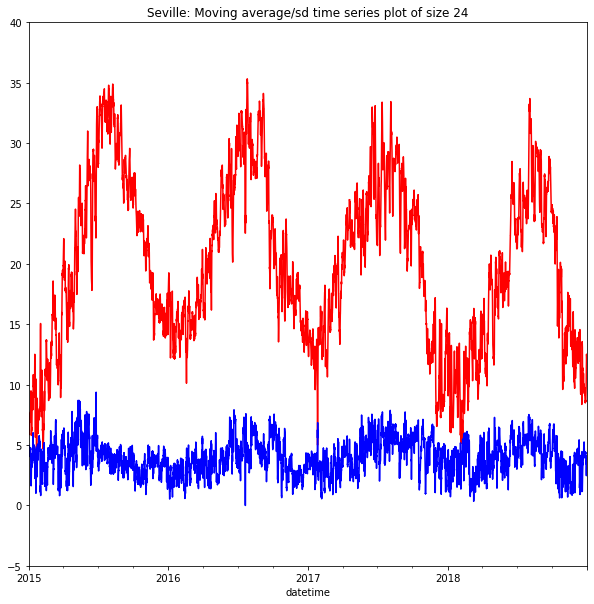

In [23]:
import matplotlib.pyplot as plt

def city_plot(data, city):
    for c in city:
        temp = data[data['city_name'] == c]
        temp = temp.set_index('datetime')
        temp_mean = temp.celsius.rolling(window = 24).mean()
        temp_std = temp.celsius.rolling(window = 24).std()
        #plot
        plt.rcParams.update({'figure.figsize':(10,10)})
        temp_mean.plot(color='red',label = 'Rolling Mean')
        temp_std.plot(color='blue',label = 'Rolling sd')
        plt.title(c+': Moving average/sd time series plot of size 24')
        plt.ylim(-5,40)
        plt.show()

city_plot(data=w1_fdate, city = ct)

Check if the time series are stationary using augmented Dickey-Fuller test. Reject the null hypotheses, so the time series are stationary.

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data, city):
    for c in city: 
        temp = data[data['city_name'] == c]
        result = adfuller(temp['celsius'])
        print(c)
        print('ADF Statistic: {}'.format(result[0]))
        print('p-value: {}'.format(result[1]))
        print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

adf_test(w1_fdate, ct)

Valencia
ADF Statistic: -5.544307058646694
p-value: 1.674289820049224e-06
Critical Values:
Madrid
ADF Statistic: -5.004913261486572
p-value: 2.170157858181531e-05
Critical Values:
Bilbao
ADF Statistic: -7.5600663660845315
p-value: 3.026598814278268e-11
Critical Values:
 Barcelona
ADF Statistic: -5.015318109004357
p-value: 2.0694994058131906e-05
Critical Values:
Seville
ADF Statistic: -5.074640307483875
p-value: 1.576192367821315e-05
Critical Values:
	1%: -3.43053679213716
	5%: -2.8616225575095284
	10%: -2.566813942767471


Here the temerature prediciton is based on the assumptions that the temperature today depends on the temperature yesterday, and that the temperature this hour depends on the temperature last hour. Two columns (cel_predday, cel_predhr) are created for these 2 assumptions.

In [17]:
w1_fdate['cel_predhr'] = w1_fdate.groupby('city_name')['celsius'].shift(1)
w1_fdate['cel_predday'] = w1_fdate.groupby('city_name')['celsius'].shift(24)
w1_fdate.head()

,city_name,celsius,datetime,date,hour,cel_predhr,cel_predday
0,Valencia,-2.675,2015-01-01 00:00:00,2015-01-01,0,NaN,NaN
1,Valencia,-2.675,2015-01-01 01:00:00,2015-01-01,1,-2.675,NaN
2,Valencia,-3.464,2015-01-01 02:00:00,2015-01-01,2,-2.675,NaN
3,Valencia,-3.464,2015-01-01 03:00:00,2015-01-01,3,-3.464,NaN
4,Valencia,-3.464,2015-01-01 04:00:00,2015-01-01,4,-3.464,NaN


Suppose we want to predict the hourly temperature of the next n days, 1<n<30, of Valencia. I randomly select a datetime as the starting point for prediction. 

In [19]:
import random
w1_val = w1_fdate[w1_fdate['city_name']=='Valencia'].reset_index()
ldate = w1_val.sample(n=1, random_state=39482)
print(ldate.datetime)
random.seed(29372)
print(random.choice(range(1,31)))

1616   2015-03-09 08:00:00
Name: datetime, dtype: datetime64[ns]
15


The train set includes the data from 2015-01-02 to 2015-03-09 08:00:00. The test set includes the data from 2015-03-09 09:00:00 to 2015-03-24 08:00:00

In [32]:
train = w1_val.iloc[:1617,:]
print(train.tail())
test = w1_val.iloc[1617:1617+15*24,:]
print(test.head())
print(test.tail())
print(test.shape)

df_val = w1_val.iloc[:1617+15*24,:]
tr_start, tr_end = train.datetime.iloc[0], train.datetime.iloc[-1]
te_start, te_end = test.datetime.iloc[0], test.datetime.iloc[-1]

      index city_name  celsius            datetime        date  hour  \
1612   1612  Valencia   8.1100 2015-03-09 04:00:00  2015-03-09     4   
1613   1613  Valencia   8.0050 2015-03-09 05:00:00  2015-03-09     5   
1614   1614  Valencia   7.9000 2015-03-09 06:00:00  2015-03-09     6   
1615   1615  Valencia   8.2300 2015-03-09 07:00:00  2015-03-09     7   
1616   1616  Valencia   6.0855 2015-03-09 08:00:00  2015-03-09     8   

      cel_predhr  cel_predday  
1612       8.470        6.420  
1613       8.110        3.499  
1614       8.005        6.490  
1615       7.900        6.640  
1616       8.230        7.690  
      index city_name  celsius            datetime        date  hour  \
1617   1617  Valencia    10.06 2015-03-09 09:00:00  2015-03-09     9   
1618   1618  Valencia    14.59 2015-03-09 10:00:00  2015-03-09    10   
1619   1619  Valencia    14.87 2015-03-09 11:00:00  2015-03-09    11   
1620   1620  Valencia    17.13 2015-03-09 12:00:00  2015-03-09    12   
1621   1621  Va

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


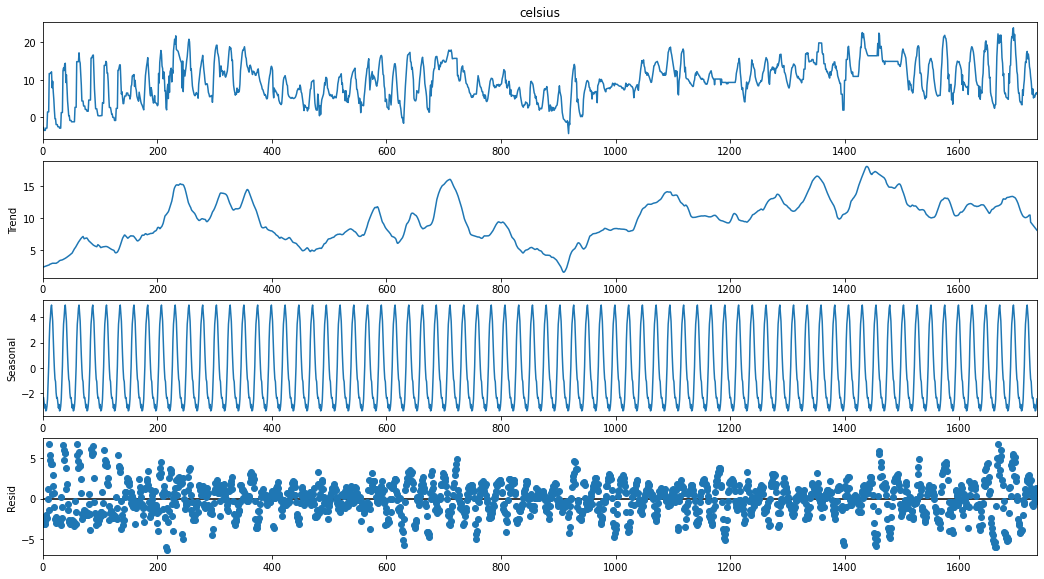

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_dcp = seasonal_decompose(df_val.celsius, model = 'additive', extrapolate_trend='freq',freq = 24)
fig = ss_dcp.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Baseline model: averaging the temperature of the previous hour and the same hour of the previous date. Compute the RMSE (using data from 2015-01-02 to 2018-12-31). 

In [33]:
#from datetime import datetime
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

#mask = (w1_fdate['date']>datetime.strptime('2015-01-01' , '%Y-%m-%d').date()) & \
#(w1_fdate['date']<datetime.strptime('2018-12-31' , '%Y-%m-%d').date())
#w1_df = w1_fdate.loc[mask]

#w1_df['cel_pred'] = (w1_df['cel_predhr']+w1_df['cel_predday'])/2
#base_err = sqrt(mse(w1_df['celsius'], w1_df['cel_pred']))
#print('RMSE for baseline model: ', base_err)

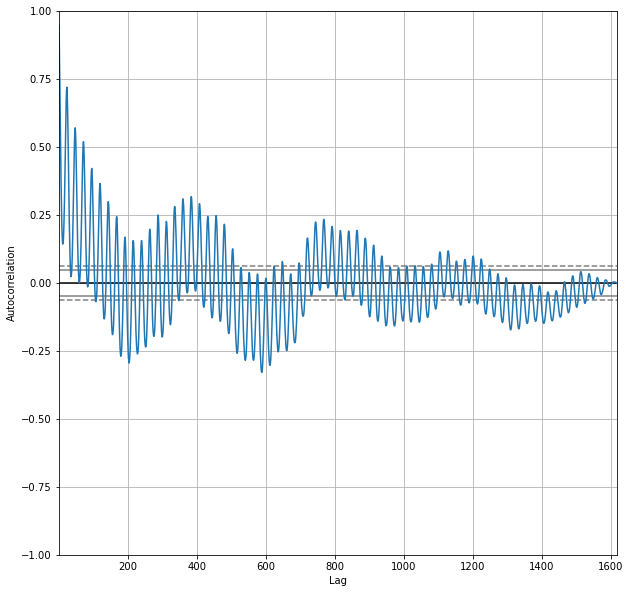

In [34]:
from pandas.plotting import autocorrelation_plot


autocorrelation_plot(train.celsius)
plt.show()




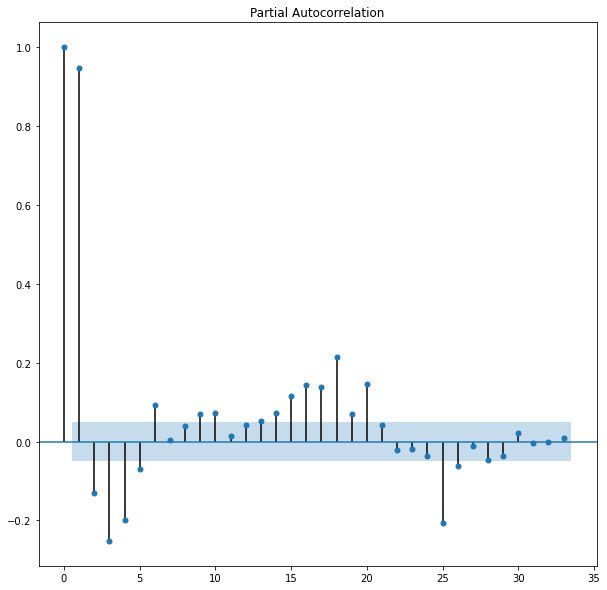

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plot_pacf(train.celsius)
plt.show()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


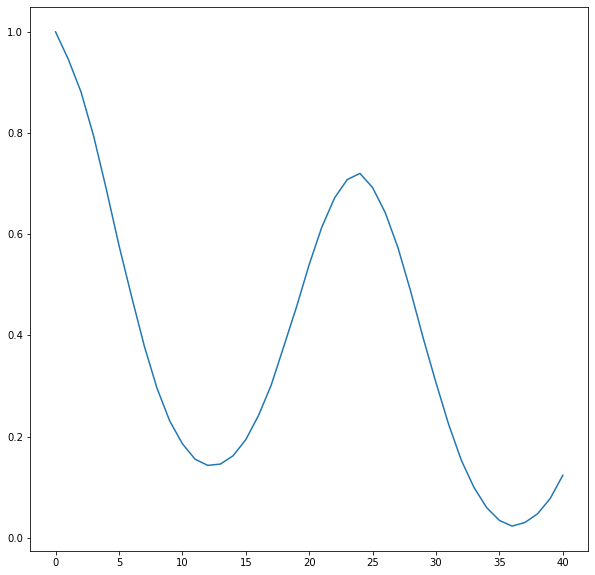

In [23]:
from statsmodels.tsa.stattools import acf

acf_cel = acf(train.celsius)
plt.plot(acf_cel)
plt.show()

SARIMA MODEL

In [36]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all differnet combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
s_pdq = [(x[0], x[1], x[2], 24) for x in pdq]


In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def best_model(pdq, s_pdq, endo):
    aic_ls = []
    for p1 in pdq:
        for p2 in s_pdq:
            model = SARIMAX(endo, order = p1,
                           seasonal_order = p2, enforce_stationarity = False,
                           enforce_invertibility = False).fit()
            aic_ls = aic_ls + [model.aic]
            if model.aic == min(aic_ls):
                parm = [p1, p2, model.aic]
    return parm
best_param = best_model(pdq = pdq, s_pdq = s_pdq, endo = train.celsius)

Model diagnostics

                                     SARIMAX Results                                      
Dep. Variable:                            celsius   No. Observations:                 1617
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -2669.011
Date:                            Mon, 31 Aug 2020   AIC                           5348.022
Time:                                    16:48:43   BIC                           5374.807
Sample:                                         0   HQIC                          5357.979
                                           - 1617                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9464      0.008    124.827      0.000       0.932       0.961
ma.L1         -0.1417      0.016   

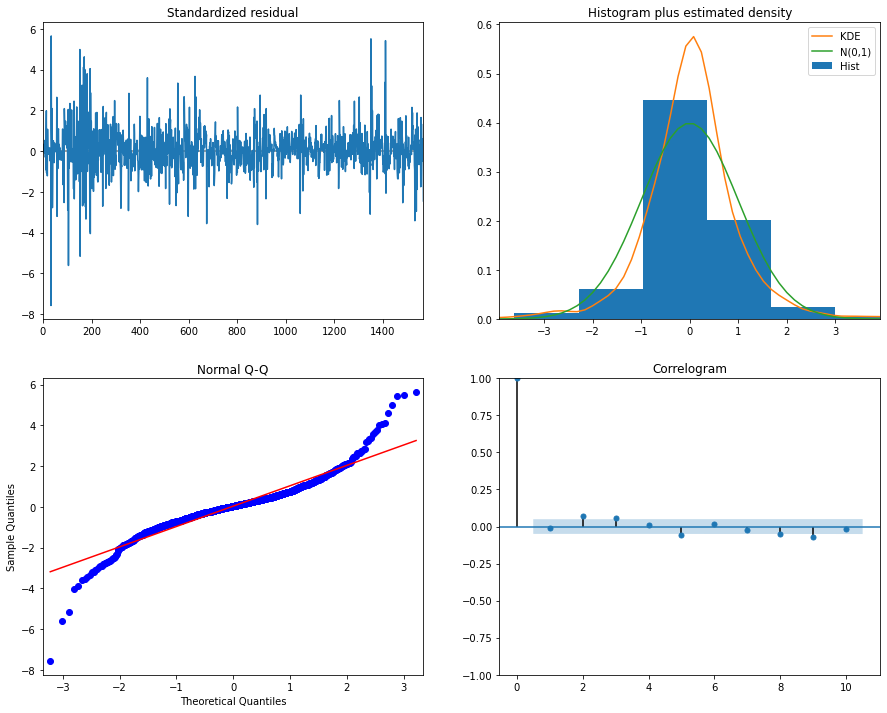

In [40]:
md = SARIMAX(train.celsius, order = (best_param[0]), 
            seasonal_order = (best_param[1]),
            enforce_stationarity = False, enforce_invertibility = False).fit()
print(md.summary())
md.plot_diagnostics(figsize=(15,12))
plt.show()

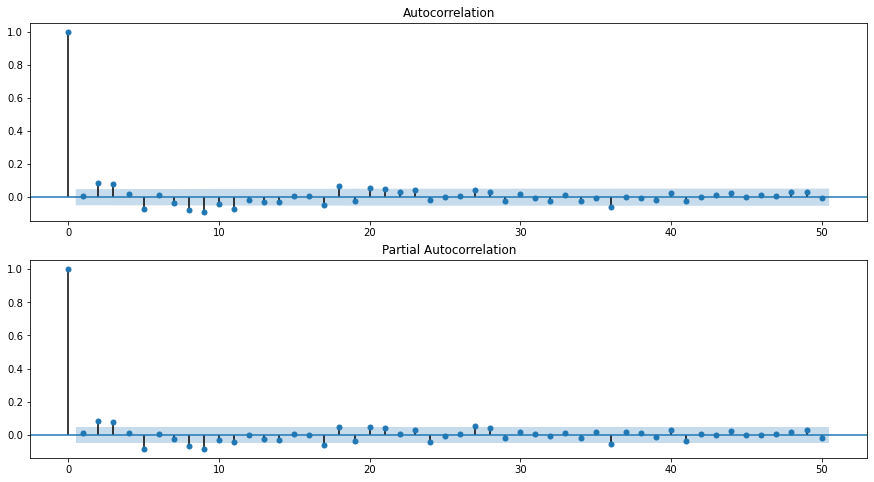

In [42]:
res = md.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(res, lags=50, ax=ax[0])
fig = plot_pacf(res, lags=50, ax=ax[1])
plt.show()

Validation

In [47]:
pred = md.forecast(steps=15*24)
print('SARIMA model RMSE:{}'.format(sqrt(mse(test.celsius,pred))))

SARIMA model RMSE:3.896641179926132


In [52]:
pred.values

numpy.ndarray

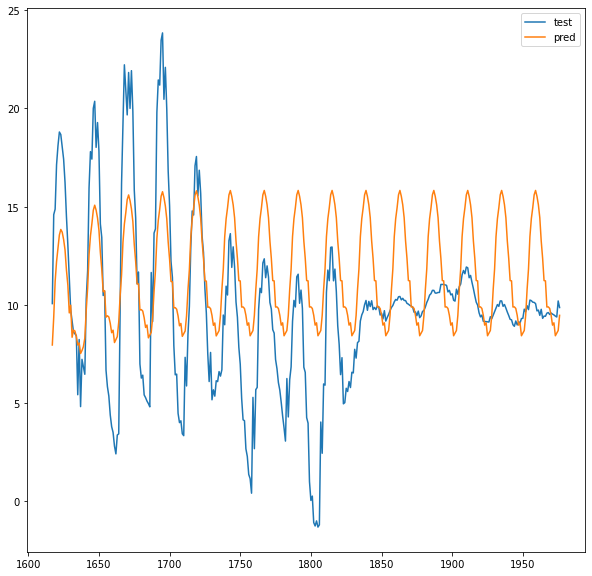

In [48]:
pd.DataFrame({'test':test.celsius,'pred':pred}).plot();plt.show()